# 02. Neural Network Classification with TensorFlow

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.


## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics).

## Typical architecture of a classification neural network

The architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

Table 1: Typical architecture of a classification network. Source: Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

## Creating data to view and fit

We could start by importing a classification dataset but let's practice making some of our own classification data.

Since classification is predicting whether something is one thing or another, let's make some data to reflect that.

To do so, we'll use Scikit-Learn's [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) function.

In [50]:
# Importing Necessary Libraries:

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore") # To not display warnings

In [3]:
# Dataset from Scikit-Learn:

from sklearn.datasets import make_circles

X, y = make_circles(n_samples= 1000,
                   noise= 0.03,
                   random_state= 42)

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X[:10], y[:10]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343],
        [-0.47964637,  0.67643477],
        [-0.01364836,  0.80334872],
        [ 0.77151327,  0.14775959],
        [-0.16932234, -0.79345575],
        [-0.1214858 ,  1.02150905]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64))

In [9]:
# Creating Dataframe from Data:

circles = pd.DataFrame({"X0": X[:, 0], 
                        "X1": X[:, 1],
                       "Label": y})

In [10]:
circles.head()

,X0,X1,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [11]:
# Checking How Many Labels are there:
circles["Label"].value_counts()

1    500
0    500
Name: Label, dtype: int64

Alright, looks like we're dealing with a **binary classification** problem. It's binary because there are only two labels (0 or 1).

If there were more label options (e.g. 0, 1, 2, 3 or 4), it would be called **multiclass classification**.

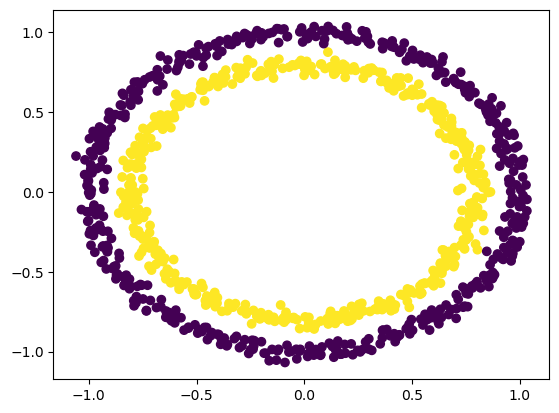

In [12]:
# Visualizing The Data:
plt.scatter(circles["X0"], circles["X1"], c = circles["Label"])
plt.show()

How about we try and build a model to classify yellow or purple dots? As in, a model which is able to distinguish yellow from purple dots.

> Before pushing forward, you might want to spend 10 minutes playing around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=2,2&seed=0.93799&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&batchSize_hide=true). Try adjusting the different hyperparameters you see and click play to see a neural network train.

## Input and output shapes

One of the most common issues you'll run into when building neural networks is shape mismatches.

More specifically, the shape of the input data and the shape of the output data.

In our case, we want to input `X` and get our model to predict `y`.

So let's check out the shapes of `X` and `y`.

In [13]:
# Checking Shapes of Features and Data:

# Features
print(X.shape)

# Label
print(y.shape)

(1000, 2)
(1000,)


In [14]:
# Checking a Single Sample of Data and it's Label:

X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

Alright, so we've got two `X` features which lead to one `y` value.

This means our neural network input shape will has to accept a tensor with at least one dimension being two and output a tensor with at least one value.

>`y` having a shape of (1000,) can seem confusing. However, this is because all `y` values are actually scalars (single values) and therefore don't have a dimension. For now, think of your output shape as being at least the same value as one example of `y` (in our case, the output from our neural network has to be at least one value).

## Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [functional](https://www.tensorflow.org/guide/keras/functional) or [sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`).

In [15]:
tf.random.set_seed(42)

model_1 = Sequential()

model_1.add(Dense(1))

model_1.compile(optimizer= "sgd",
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

model_1.fit(X, y, epochs= 10)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4733 - loss: 6.9135 
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4527 - loss: 6.5416 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4533 - loss: 6.6187
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4593 - loss: 6.3316 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4382 - loss: 4.9217 
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.4632 - loss: 2.8105
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.4751 - loss: 0.7737
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.4702 - loss: 0.7238
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.4681 - loss: 0.7076
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4663 - loss: 0.7010 


Looking at the accuracy metric, our model performs poorly (46% accuracy on a binary classification problem is the equivalent of guessing).

Let's try Training for Longer.

In [16]:
model_1.fit(X, y, epochs= 200)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4617 - loss: 0.6980
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4571 - loss: 0.6966
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4419 - loss: 0.6958
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4350 - loss: 0.6954
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4332 - loss: 0.6952
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4447 - loss: 0.6950 
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4445 - loss: 0.6950 
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.4350 - loss: 0.6949
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4379 - loss: 0.6949  
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4323 - loss: 0.6949
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4288 - loss: 0.6949
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 136/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4271 - loss: 0.6948  
Epoch 137/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4271 - loss: 0.6948  
Epoch 138/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 139/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 140/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4271 - loss: 0.6948 
Epoch 141/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 142/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4271 - loss: 0.6948
Epoch 143/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.4271 - loss: 0.6948
Epoch 144/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4271 - loss: 0.6948 
Epoch 145/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4271 - loss: 0.6948 
Epoch 146/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

Still, The Accuracy is very Poor (42.7%).

In [17]:
# Adding an Extra Layer:

tf.random.set_seed(42)

model_2 = Sequential()

model_2.add(Dense(1))
model_2.add(Dense(1))

model_2.compile(optimizer= "sgd",
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

model_2.fit(X, y, epochs= 200)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4144 - loss: 3.8303   
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5201 - loss: 0.7290
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5247 - loss: 0.6987
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5157 - loss: 0.6952
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4824 - loss: 0.6947
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4681 - loss: 0.6947 
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4438 - loss: 0.6948 
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4633 - loss: 0.6948 
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.4550 - loss: 0.6948
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.4555 - loss: 0.6948
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4546 - loss: 0.6948 
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/ste

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4500 - loss: 0.6948 
Epoch 136/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4500 - loss: 0.6948
Epoch 137/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4500 - loss: 0.6948
Epoch 138/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4500 - loss: 0.6948
Epoch 139/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4500 - loss: 0.6948
Epoch 140/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.4500 - loss: 0.6948
Epoch 141/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.4500 - loss: 0.6948
Epoch 142/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.4500 - loss: 0.6948
Epoch 143/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.4500 - loss: 0.6948
Epoch 144/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4500 - loss: 0.6948
Epoch 145/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4501 - loss: 0.6948
Epoch 146/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

Accuracy is still 45%. Worse than Guessing.

## Improving a model

To improve our model, we can alter almost every part of the 3 steps we went through before.

1. **Creating a model** - here you might want to add more layers, increase the number of hidden units (also called neurons) within each layer, change the activation functions of each layer.
2. **Compiling a model** - you might want to choose a different optimization function (such as the [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer, which is usually pretty good for many problems) or perhaps change the learning rate of the optimization function.
3. **Fitting a model** - perhaps you could fit a model for more epochs (leave it training for longer).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

In [18]:
# Adding More Neurons, layers and Changing Optimizer:

tf.random.set_seed(42)

model_3 = Sequential()

model_3.add(Dense(100))
model_3.add(Dense(10))
model_3.add(Dense(1))

model_3.compile(optimizer= "adam",
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

model_3.fit(X, y, epochs= 200)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4830 - loss: 3.3584
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4830 - loss: 0.8213
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4830 - loss: 0.7875
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4830 - loss: 0.7667
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4830 - loss: 0.7498 
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4830 - loss: 0.7360
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4830 - loss: 0.7247
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4830 - loss: 0.7156
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4830 - loss: 0.7084
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4830 - loss: 0.7030
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4830 - loss: 0.6990
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4610 - loss: 0.6974  
Epoch 137/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4611 - loss: 0.6974
Epoch 138/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4572 - loss: 0.6975  
Epoch 139/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4572 - loss: 0.6975
Epoch 140/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4574 - loss: 0.6976
Epoch 141/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4557 - loss: 0.6977
Epoch 142/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4557 - loss: 0.6977
Epoch 143/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4557 - loss: 0.6978
Epoch 144/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4557 - loss: 0.6978 
Epoch 145/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4586 - loss: 0.6979
Epoch 146/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4574 - loss: 0.6979 
Epoch 147/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

Still, Same Accuracy!

Let's make some visualizations to see what's happening.

Whenever your model is performing strangely or there's something going on with your data you're not quite sure of, remember to **Visualize**. Inspect your data, inspect your model, inpsect your model's predictions.

To visualize our model's predictions we're going to create a function `plot_decision_boundary()` which:
* Takes in a trained model, features (`X`) and labels (`y`).
* Creates a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) of the different `X` values.
* Makes predictions across the meshgrid.
* Plots the predictions as well as a line between the different zones (where each unique class falls).

If you're ever unsure of what a function does, try unraveling it and writing it line by line for yourself to see what it does. Break it into small parts and see what each part outputs.

In [19]:
import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...


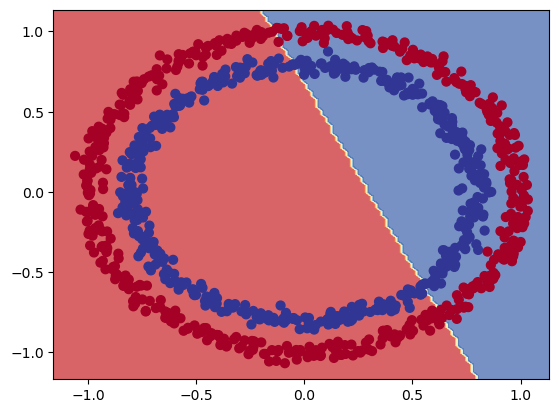

In [20]:
# Let's Check How Our Model is Working in Finding Decision Boundry between 
# Clesses.

plot_decision_boundary(model_3, X, y)

Looks like our model is trying to draw a straight line through the data.

The main issue is our data isn't separable by a straight line.

In a regression problem, our model might work.

In [34]:
# Trying Same Model on Regression Data:

# Creating Regression Data:

X_reg = tf.range(start= 0, limit= 1000, delta= 5)
y_reg = tf.range(start= 100, limit= 1100, delta= 5)

# Train Test Split:

X_reg_train = X_reg[:150]
X_reg_test = X_reg[150:]
y_reg_train = y_reg[:150]
y_reg_test = y_reg[150:]

In [35]:
X_reg_train.shape, X_reg_test.shape, y_reg_train.shape, y_reg_test.shape

(TensorShape([150]), TensorShape([50]), TensorShape([150]), TensorShape([50]))

In [41]:
# Building Model Same as "model_3" for Regression:

tf.random.set_seed(42)

model_3_reg = Sequential()

model_3_reg.add(Dense(100))
model_3_reg.add(Dense(10))
model_3_reg.add(Dense(1))

model_3_reg.compile(optimizer= "adam",
               loss= "mae",
               metrics= ["mae"])

model_3_reg.fit(tf.reshape(X_reg_train, shape= [150,1]),
                           y_reg_train, 
                           epochs= 200)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 145.6317 - mae: 145.6317
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.2426 - mae: 47.2426 
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 69.2809 - mae: 69.2809  
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.4550 - mae: 45.4550 
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.7053 - mae: 46.7053 
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.7324 - mae: 41.7324 
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.5939 - mae: 42.5939 
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41.7493 - mae: 41.7493 
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.1604 - mae: 40.1604 
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.9118 - mae: 41.9118 
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.2539 - mae: 40.2539  
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.3449 - mae: 40.3449  
Epoch 13/200
5/5 ━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.6756 - mae: 30.6756 
Epoch 142/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.3084 - mae: 30.3084 
Epoch 143/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.3090 - mae: 30.3090 
Epoch 144/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.9357 - mae: 29.9357 
Epoch 145/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.4408 - mae: 30.4408 
Epoch 146/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.3421 - mae: 29.3421  
Epoch 147/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.4781 - mae: 29.4781 
Epoch 148/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.2366 - mae: 29.2366 
Epoch 149/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 29.0072 - mae: 29.0072 
Epoch 150/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.6962 - mae: 28.6962 
Epoch 151/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.4272 - mae: 29.4272 
Epoch 152/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.1932 - mae: 28.1932  
Epoch 153/200
5/

In [42]:
# making Prediction on Regression Test Data:

y_reg_pred = model_3_reg.predict(y_reg_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


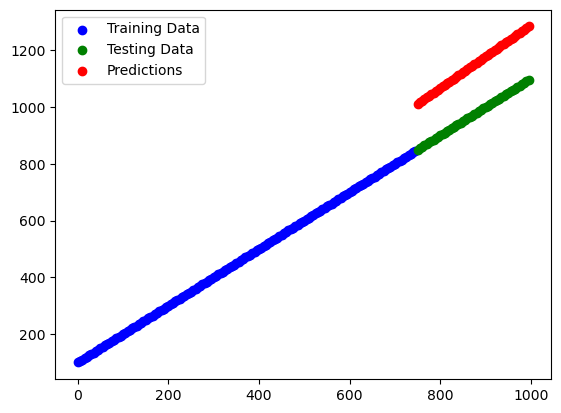

In [43]:
# Plotting Regression Training and Test Data with Predictions:

plt.scatter(X_reg_train, y_reg_train, c= "blue", label= "Training Data")
plt.scatter(X_reg_test, y_reg_test, c= "green", label= "Testing Data")
plt.scatter(X_reg_test, y_reg_pred, c= "red", label= "Predictions")
plt.legend()
plt.show()

Okay, the predictions aren't perfect (if the predictions were perfect, the red would line up with the green), but they look better than complete guessing.

So this means our model must be learning something.

There must be something we're missing out on for our classification problem.

## The missing piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and blue circles), we're going to need some non-linear lines.

The main change we'll add to models we've built before is the use of the `activation` keyword.

In [46]:
# Introducing Nin-Linearity in The Model Using 
# Activation Functions in Hidden Layers:

tf.random.set_seed(42)

model_4 = Sequential()

model_4.add(Dense(4, activation= "relu"))
model_4.add(Dense(4, activation= "relu"))
model_4.add(Dense(1))

model_4.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.01),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

model_4.fit(X, y, epochs= 200)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4807 - loss: 4.1503
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4395 - loss: 0.7525
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4983 - loss: 0.7012
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5375 - loss: 0.6779
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5413 - loss: 0.6660 
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5616 - loss: 0.6602
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5568 - loss: 0.6571
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5654 - loss: 0.6536
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5810 - loss: 0.6443
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6032 - loss: 0.6298
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6110 - loss: 0.6116
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

Epoch 137/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5865 - loss: 0.6372
Epoch 138/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5869 - loss: 0.6372
Epoch 139/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5865 - loss: 0.6372 
Epoch 140/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5868 - loss: 0.6368 
Epoch 141/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5865 - loss: 0.6372 
Epoch 142/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5884 - loss: 0.6367
Epoch 143/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5890 - loss: 0.6369
Epoch 144/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.5896 - loss: 0.6365
Epoch 145/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5891 - loss: 0.6368
Epoch 146/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5891 - loss: 0.6364
Epoch 147/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5898 - loss: 0.6363
Epoch 148/200
32/32 ━━━━━━━━━━━━━━━━━━

In [47]:
model_4.evaluate(X, y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6601 - loss: 0.5819


[0.586776852607727, 0.6480000019073486]

Accuracy is Still Outrageous.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...


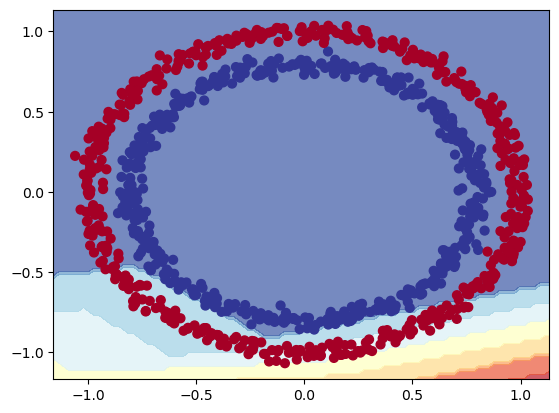

In [51]:
# Plotting Predictions:

plot_decision_boundary(model_4, X, y)

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the [Sigmoid activation function](https://www.tensorflow.org/api_docs/python/tf/math/sigmoid).

In [52]:
tf.random.set_seed(42)

model_5 = Sequential()

model_5.add(Dense(4, activation= "relu"))
model_5.add(Dense(4, activation= "relu"))
model_5.add(Dense(1, activation= "sigmoid"))

model_5.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.01),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

model_5.fit(X, y, epochs= 200)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4892 - loss: 0.6945
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5252 - loss: 0.6914
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5218 - loss: 0.6879
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5236 - loss: 0.6809
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5684 - loss: 0.6713 
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5765 - loss: 0.6617
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6043 - loss: 0.6500
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6364 - loss: 0.6312
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6953 - loss: 0.6020
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7340 - loss: 0.5759
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7564 - loss: 0.5423 
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accurac

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0229 
Epoch 138/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0229
Epoch 139/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0228
Epoch 140/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0228
Epoch 141/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0227
Epoch 142/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0227
Epoch 143/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0226
Epoch 144/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0226
Epoch 145/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0226
Epoch 146/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0225
Epoch 147/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9938 - loss: 0.0225
Epoch 148/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

We have almost 100% Accuracy.

In [53]:
model_5.evaluate(X,y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9908 - loss: 0.0246


[0.02243472822010517, 0.9919999837875366]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
doing binary classifcation...


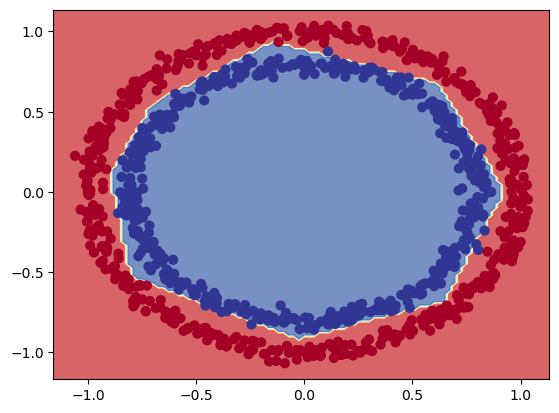

In [54]:
# Plotting Predictions:
plot_decision_boundary(model_5, X, y)

> 🔑 **Note:** The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neural networks.

Think of it like this:

If I gave you an unlimited amount of straight lines and non-straight lines, what kind of patterns could you draw?

That's essentially what neural networks do to find patterns in data.

Now you might be thinking, "but I haven't seen a linear function or a non-linear function before..."

Oh but you have.

We've been using them the whole time.

They're what power the layers in the models we just built.

To get some intuition about the activation functions we've just used, let's create them and then try them on some toy data.

In [55]:
# Creating a Toy Tensor:

a = tf.cast(tf.range(-10,10), tf.float32)

In [56]:
a

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

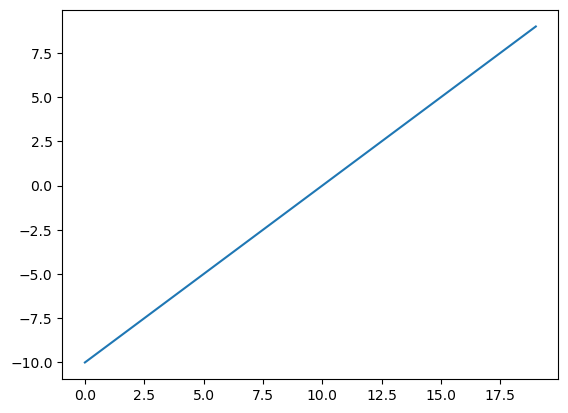

In [57]:
# Visualize Toy Tensor:
plt.plot(a)
plt.show()

Nice, now let's recreate the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) and see what it does to our data. You can also find a pre-built sigmoid function at [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid).

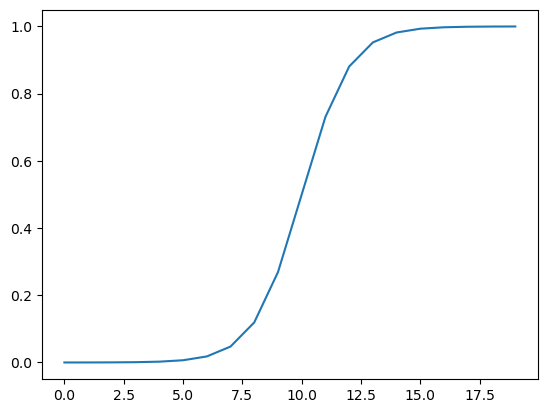

In [60]:
# Plotting Toy Tensor after Applying Sigmoid Function on it:
plt.plot(tf.keras.activations.sigmoid(a))
plt.show()

How about the [ReLU function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.) (ReLU turns all negatives to 0 and positive numbers stay the same)?

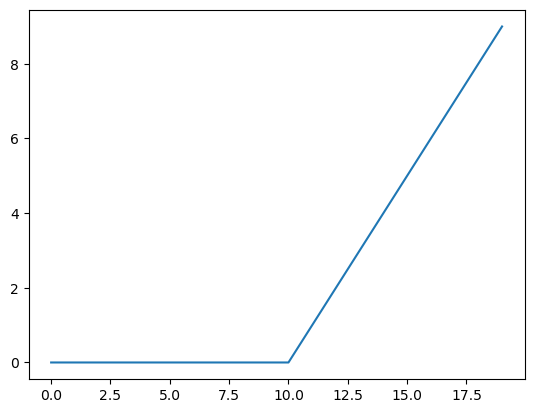

In [62]:
# Plotting Toy Tensor after Applying Relu Function on it:
plt.plot(tf.keras.activations.relu(a))
plt.show()

How about TensorFlow's [linear activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear)?

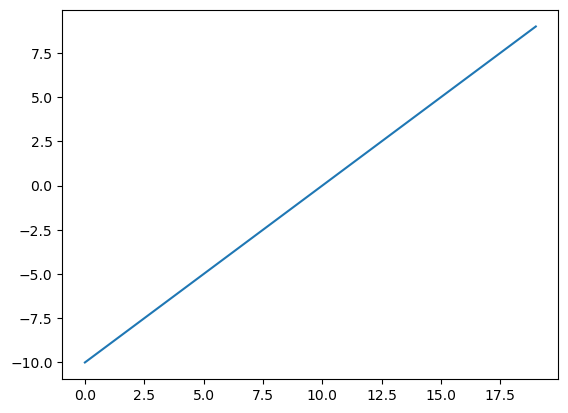

In [63]:
# Plotting Toy Tensor after Applying Linear Function on it:
plt.plot(tf.keras.activations.linear(a))
plt.show()

In [64]:
# Seems like Linear Functions doesn't change anything in Toy Tensor
a == tf.keras.activations.linear(a)

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])>

Okay, so it makes sense now the model doesn't really learn anything when using only linear activation functions, because the linear activation function doesn't change our input data in anyway.

Where as, with our non-linear functions, our data gets manipulated. A neural network uses these kind of transformations at a large scale to figure draw patterns between its inputs and outputs.

For more on activation functions, check out the [machine learning cheatsheet page](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#) on them.

## Evaluating and improving our classification model


We've been evaluating our model on the same data it was trained on.

A better approach would be to split our data into training, validation (optional) and test sets.

Once we've done that, we'll train our model on the training set (let it find patterns in the data) and then see how well it learned the patterns by using it to predict values on the test set.

In [66]:
# Shape of Our Data:
X.shape, y.shape

((1000, 2), (1000,))

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
# Train Test Split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,
                                                   random_state= 42)

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [73]:
# Creating Neural Network: (Same as model_5):

tf.random.set_seed(42)

model_6 = Sequential()

model_6.add(Dense(4, activation= "relu"))
model_6.add(Dense(4, activation= "relu"))
model_6.add(Dense(1, activation= "sigmoid"))

model_6.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.01),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

history = model_6.fit(X_train, y_train, epochs= 50)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4563 - loss: 0.6944 
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 0.6902
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5340 - loss: 0.6855 
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5576 - loss: 0.6788
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5767 - loss: 0.6699
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5890 - loss: 0.6580 
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6535 - loss: 0.6422
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6898 - loss: 0.6199 
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6982 - loss: 0.5920  
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7686 - loss: 0.5540 
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7789 - loss: 0.5197 
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8

In [74]:
# Evaluating The Model:
model_6.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9865 - loss: 0.0596  


[0.06032460555434227, 0.9900000095367432]

In [72]:
# 99% Accuracy on Test Data.

Now, when we started to create `model_6` we said it was going to be the same as `model_5` but you might've found that to be a little lie.

That's because we changed a few things:
* **The `learning_rate` (also `lr`) parameter** - We increased the **learning rate** parameter in the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) to `0.01` instead of `0.001` (an increase of 10x).
  * You can think of the learning rate as how quickly a model learns. The higher the learning rate, the faster the model's capacity to learn, however, there's such a thing as a *too high* learning rate, where a model tries to learn too fast and doesn't learn anything.
* **The number of epochs** - We lowered the number of epochs (using the `epochs` parameter) from 200 to 50 but our model still got an incredible result on both the training and test sets.
  * One of the reasons our model performed well in even less epochs (remember a single epoch is the model trying to learn patterns in the data by looking at it once, so 50 epochs means the model gets 50 chances) than before is because we increased the learning rate.

We know our model is performing well based on the evaluation metrics but let's see how it performs visually.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
doing binary classifcation...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
doing binary classifcation...


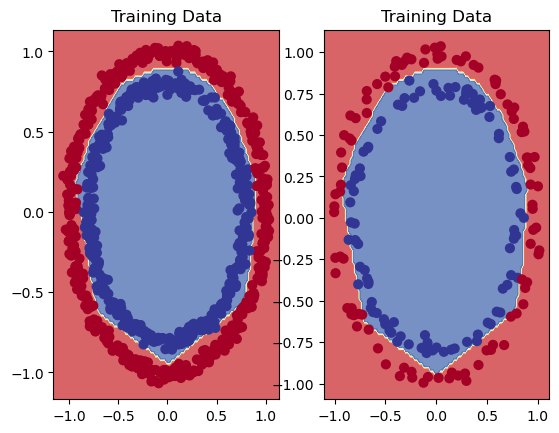

In [78]:
# Plotting Model's Decision Boundries for Training and Test Data:

plt.subplot(1,2,1)
plt.title("Training Data")
plot_decision_boundary(model_6, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Training Data")
plot_decision_boundary(model_6, X_test, y_test)

plt.show()

### Plot the loss curves

Looking at the plots above, we can see the outputs of our model are very good.

But how did our model go whilst it was learning?

As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

To figure this out, we can check the **loss curves** (also referred to as the **learning curves**).

You might've seen we've been using the variable `history` when calling the `fit()` function on a model ([`fit()` returns a `History` object](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)).

This is where we'll get the information for how our model is performing as it learns.

In [79]:
history

In [81]:
type(history.history)

dict

In [83]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

In [85]:
pd.DataFrame(history.history).head(10)

,accuracy,loss
0,0.47375,0.693492
1,0.50875,0.690111
2,0.53625,0.685816
3,0.55625,0.679566
4,0.56750,0.670864
5,0.58625,0.658620
6,0.64875,0.642049
7,0.69625,0.618322
8,0.71750,0.587371
9,0.76500,0.549184


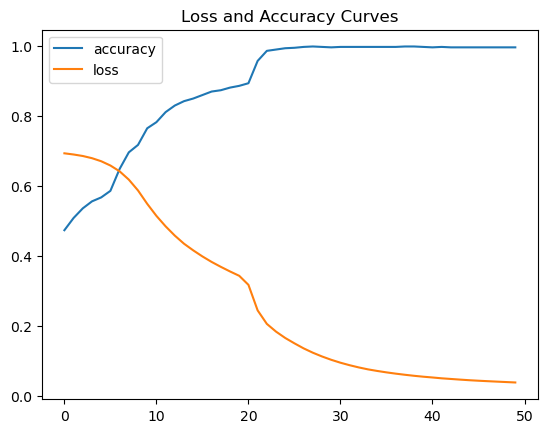

In [87]:
# Plotting Loss and Accuracy Curves:

pd.DataFrame(history.history).plot()
plt.title("Loss and Accuracy Curves")
plt.show()

This is the ideal plot we'd be looking for when dealing with a classification problem, loss going down, accuracy going up.

**For many problems, the loss function going down means the model is improving (the predictions it's making are getting closer to the ground truth labels).**

### Finding the best learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the most important hyperparameter you can tune for your neural network models is the **learning rate**.

In `model_6` we lowered the Adam optimizer's learning rate from the default of `0.001` (default) to `0.01`.

That's an important thing to understand about machine learning and deep learning in general. It's very experimental. You build a model and evaluate it, build a model and evaluate it.

That being said, let's see a trick which will help find the optimal learning rate (at least to begin training with) for your models going forward.

To do so, we're going to use the following:
* A [learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
   * You can think of a callback as an extra piece of functionality you can add to your model *while* its training.
* Another model (we could use the same ones as above).
* A modified loss curves plot.

**Note:** The default hyperparameters of many neural network building blocks in TensorFlow are setup in a way which usually work right out of the box (e.g. the [Adam optimizer's](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) default settings can usually get good results on many datasets). So it's a good idea to try the defaults first, then adjust as needed.

In [96]:
# Creating Same Model as Above with Learning Rate Callback:

tf.random.set_seed(42)

model_7 = Sequential()

model_7.add(Dense(4, activation= "relu"))
model_7.add(Dense(4, activation= "relu"))
model_7.add(Dense(1, activation= "sigmoid"))

model_7.compile(optimizer= tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

# Creatina a Learning Rate Schedulaer Callback
lr_schedular = tf.keras.callbacks.LearningRateScheduler(
                                        lambda epoch: 1e-4 * 10**(epoch/20)) 
# traverse a set of learning rate values starting from 1e-4, 
# increasing by 10**(epoch/20) every epoch

history_7 = model_7.fit(X_train, y_train, epochs= 100,
                       callbacks= [lr_schedular])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5025 - loss: 0.7079 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5025 - loss: 0.7065 - learning_rate: 1.1220e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5025 - loss: 0.7050 - learning_rate: 1.2589e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5025 - loss: 0.7034 - learning_rate: 1.4125e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5025 - loss: 0.7018 - learning_rate: 1.5849e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5025 - loss: 0.7000 - learning_rate: 1.7783e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5025 - loss: 0.6982 - learning_rate: 1.9953e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5025 - loss: 0.6964 - learning_rate: 2.2387e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5025 - loss: 0.6945 - learning_

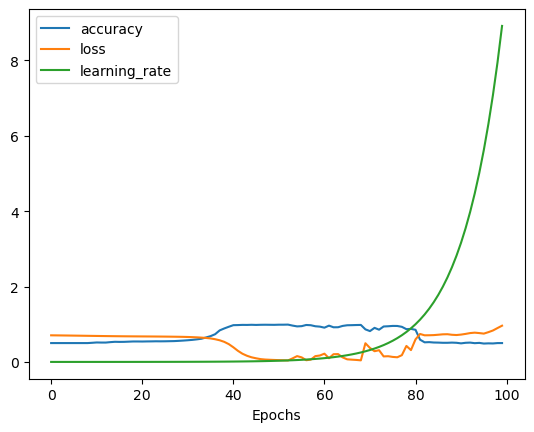

In [97]:
# Checking Out History of Model:

pd.DataFrame(history_7.history).plot()
plt.xlabel("Epochs")
plt.show()

In [98]:
# Learning Rates Used per Epoch:
lrs = 1e-4 * (10 ** (tf.range(100)/20))
lrs

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([1.00000000e-04, 1.12201845e-04, 1.25892541e-04, 1.41253754e-04,
       1.58489319e-04, 1.77827941e-04, 1.99526231e-04, 2.23872114e-04,
       2.51188643e-04, 2.81838293e-04, 3.16227766e-04, 3.54813389e-04,
       3.98107171e-04, 4.46683592e-04, 5.01187234e-04, 5.62341325e-04,
       6.30957344e-04, 7.07945784e-04, 7.94328235e-04, 8.91250938e-04,
       1.00000000e-03, 1.12201845e-03, 1.25892541e-03, 1.41253754e-03,
       1.58489319e-03, 1.77827941e-03, 1.99526231e-03, 2.23872114e-03,
       2.51188643e-03, 2.81838293e-03, 3.16227766e-03, 3.54813389e-03,
       3.98107171e-03, 4.46683592e-03, 5.01187234e-03, 5.62341325e-03,
       6.30957344e-03, 7.07945784e-03, 7.94328235e-03, 8.91250938e-03,
       1.00000000e-02, 1.12201845e-02, 1.25892541e-02, 1.41253754e-02,
       1.58489319e-02, 1.77827941e-02, 1.99526231e-02, 2.23872114e-02,
       2.51188643e-02, 2.81838293e-02, 3.16227766e-02, 3.54813389e-02,
       3.98107171e-02, 4.4668

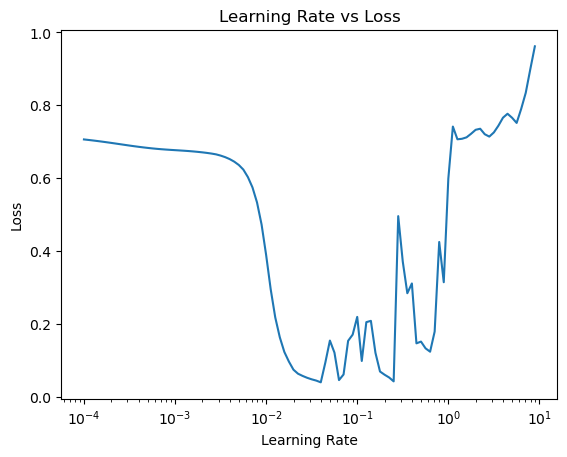

In [99]:
# Plotting Learning rate vs Loss:

plt.semilogx(lrs, history_7.history["loss"]) # X axis in a Log Scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs Loss")
plt.show()

To figure out the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`.

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (a value where the loss is still decreasing).*

Now we've estimated the ideal learning rate (we'll use `0.02`) for our model, let's refit it.

In [101]:
# Building Neural Network with New Learning Rate found Using Callback:

tf.random.set_seed(42)

model_8 = Sequential()

model_8.add(Dense(4, activation= "relu"))
model_8.add(Dense(4, activation= "relu"))
model_8.add(Dense(1, activation= "sigmoid"))

model_8.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.02),
               loss = tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

history_8= model_8.fit(X_train, y_train, epochs= 50)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4870 - loss: 0.6963
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4956 - loss: 0.6910 
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5005 - loss: 0.6878 
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5322 - loss: 0.6775 
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5671 - loss: 0.6672 
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6282 - loss: 0.6429 
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6720 - loss: 0.6006 
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7487 - loss: 0.5420
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7631 - loss: 0.4841 
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.8511 - loss: 0.4264
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9222 - loss: 0.3251 
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0

With a little higher learning rate (`0.02` instead of `0.01`) we reach a higher accuracy than `model_6`.

In [102]:
# Evaluate The Model:
model_8.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0273  


[0.022273069247603416, 0.9900000095367432]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
doing binary classifcation...


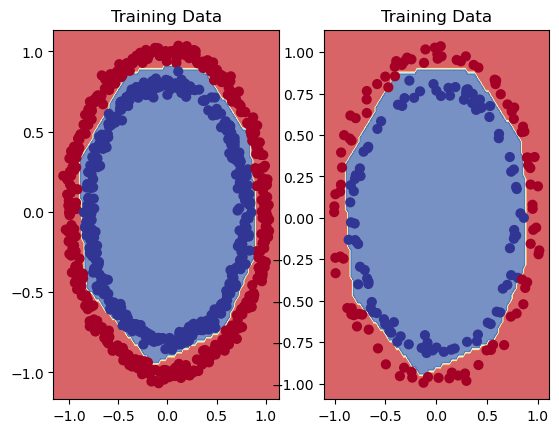

In [103]:
# Plotting Model's Decision Boundries for Training and Test Data:

plt.subplot(1,2,1)
plt.title("Training Data")
plot_decision_boundary(model_8, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Training Data")
plot_decision_boundary(model_8, X_test, y_test)

plt.show()

And as we can see, almost perfect again.

These are the kind of experiments we'll be running often when building your own models.

Start with default settings and see how they perform on your data.

And if they don't perform as well as you'd like, improve them.

### More classification evaluation methods

There are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Note: Every classification problem will require different kinds of evaluation methods. But you should be familiar with at least the ones above.

Because we passed `["accuracy"]` to the `metrics` parameter when we compiled our model, calling `evaluate()` on it will return the loss as well as accuracy.

In [104]:
# Accuracy:

loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Accuracy on Test Data is : {accuracy*100}%") # *100 to Convert Accuracy
# in Percentage

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9823 - loss: 0.0273 
Accuracy on Test Data is : 99.00000095367432%


- Confusion Matrix:

![anatomy of a confusion matrix](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-anatomy-of-a-confusion-matrix.png)
*Anatomy of a confusion matrix. Correct predictions appear down the diagonal (from top left to bottom right).*

We can make a confusion matrix using [Scikit-Learn's `confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method.

In [105]:
# Import Confusion Matrix Function from Scikit-Learn:
from sklearn.metrics import confusion_matrix

# Making Predictions Using Our Model:
y_pred = model_8.predict(X_test)

# Creating Confusin Matrix:
confusion_matrix(y_test, y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [106]:
# Checking Values in Test Data:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], dtype=int64)

In [107]:
# Checking values in Predictions:
y_pred[:10]

array([[9.9989736e-01],
       [4.9691391e-03],
       [9.9999744e-01],
       [1.5299255e-04],
       [9.9252546e-01],
       [9.8175746e-01],
       [7.0413789e-03],
       [7.0060707e-07],
       [9.9991369e-01],
       [1.7480203e-03]], dtype=float32)

It looks like we need to get our predictions into the binary format (0 or 1).

In their current format (`9.8526537e-01`), they're in a form called **prediction probabilities**.

We'll see this often with the outputs of neural networks. Often they won't be exact values but more a probability of how *likely* they are to be one value or another.

So one of the steps you'll often see after making predicitons with a neural network is converting the prediction probabilities into labels.

In our case, since our ground truth labels (`y_test`) are binary (0 or 1), we can convert the prediction probabilities using to their binary form using [`tf.round()`](https://www.tensorflow.org/api_docs/python/tf/math/round).

In [108]:
tf.round(y_pred)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [109]:
# Creating a Confusion Matrix:
confusion_matrix(y_test, tf.round(y_pred))

array([[ 98,   2],
       [  0, 100]], dtype=int64)

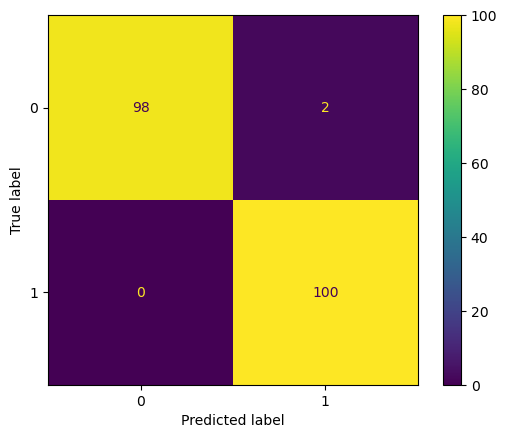

In [112]:
# Displaying Confusion Matrix Using Scikit-Learn
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

from sklearn.metrics import ConfusionMatrixDisplay

# Creating a Confusion Matrix Using Function to store it and Display it later:
cm = confusion_matrix(y_test, tf.round(y_pred))

# Creating Confusion Matrix Plot:
display = ConfusionMatrixDisplay(cm)

# Displaying Confusion Matrix Plot:
display.plot()
plt.show()

## Working with a larger example (multiclass classification)

We've seen a binary classification example (predicting if a data point is part of a red circle or blue circle) but what if you had multiple different classes of things?

For example, say you were a fashion company and you wanted to build a neural network to predict whether a piece of clothing was a shoe, a shirt or a jacket (3 different options).

When you have more than two classes as an option, this is known as **multiclass classification**.

The good news is, the things we've learned so far (with a few tweaks) can be applied to multiclass classification problems as well.

To start, we'll need some data. The good thing for us is TensorFlow has a multiclass classication dataset known as [Fashion MNIST built-in](https://github.com/zalandoresearch/fashion-mnist).

We can import it using the [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) module.

In [40]:
# Importing Necessary Libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Flatten

In [2]:
# importing Dataset:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
fashion_mnist

<module 'keras.api.datasets.fashion_mnist' from 'C:\\Users\\shail\\AppData\\Roaming\\Python\\Python311\\site-packages\\keras\\api\\datasets\\fashion_mnist\\__init__.py'>

In [4]:
# The data has already been sorted into training and test sets for us
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 36s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 4s 1us/step


In [5]:
# First Training Sample:
train_data[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [6]:
# First Training Lable:
train_labels[0]

9

In [7]:
# Shape of Data:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [8]:
# Shape of a Single Sample:
train_data[0].shape, train_labels[0].shape

((28, 28), ())

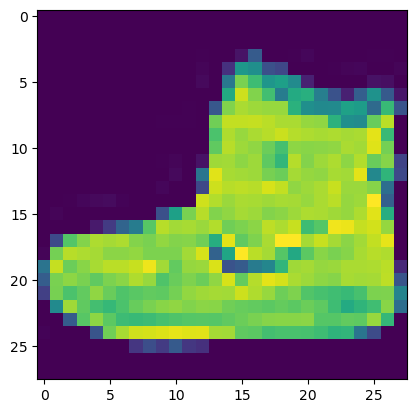

In [9]:
# Plotting a Single Example:
plt.imshow(train_data[0])
plt.show()

In [10]:
# Creating a List of Class Names:
# https://github.com/zalandoresearch/fashion-mnist#labels

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
len(class_names)

10

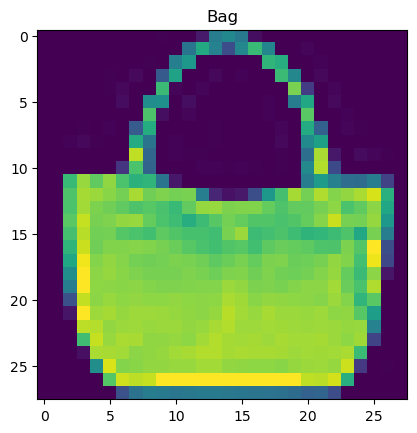

In [14]:
# Plotting Another Sample from Data and It's Label:

image_number = 100

plt.imshow(train_data[image_number])
plt.title(class_names[train_labels[image_number]])
plt.show()

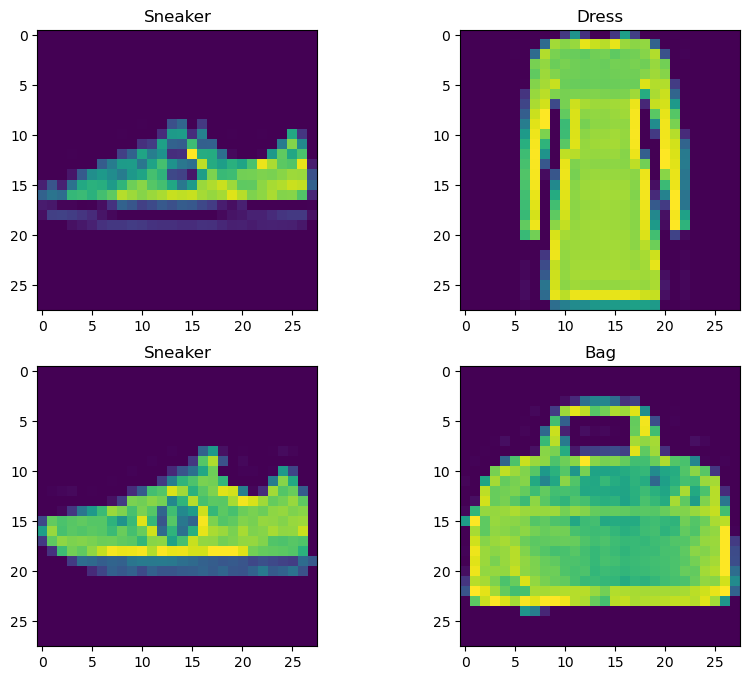

In [19]:
# Plotting Multiple Random Images from Data:

import random
plt.figure(figsize= (10,8))

for i in range(4):
    
    ax = plt.subplot(2, 2, i+1)
    random_index = random.choice(range(len(train_data)))
    plt.imshow(train_data[random_index])
    plt.title(class_names[train_labels[random_index]])

Alright, let's build a model to figure out the relationship between the pixel values and their labels.

Since this is a multiclass classification problem, we'll need to make a few changes to our architecture:

* The **input shape** will have to deal with 28x28 tensors (the height and width of our images).
  * We're actually going to squash the input into a tensor (vector) of shape `(28*28= 784)`.
* The **output shape** will have to be 10 because we need our model to predict for 10 different classes.
  * We'll also change the `activation` parameter of our output layer to be [`"softmax"`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) instead of `'sigmoid'`. As we'll see the `"softmax"` activation function outputs a series of values between 0 & 1 (the same shape as **output shape**, which together add up to ~1. The index with the highest value is predicted by the model to be the most *likely* class.
* We'll need to change our loss function from a binary loss function to a multiclass loss function.
  * More specifically, since our labels are in integer form, we'll use [`tf.keras.losses.SparseCategoricalCrossentropy()`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), if our labels were one-hot encoded (e.g. they looked something like `[0, 0, 1, 0, 0...]`), we'd use [`tf.keras.losses.CategoricalCrossentropy()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy).
* We'll also use the `validation_data` parameter when calling the `fit()` function. This will give us an idea of how the model performs on the test set during training.


In [29]:
# Building a Neural Network:

tf.random.set_seed(42)

model_9 = Sequential()

model_9.add(InputLayer(shape= (28,28)))
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer

model_9.add(Flatten())
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

model_9.add(Dense(4, activation= "relu"))
model_9.add(Dense(4, activation= "relu"))
model_9.add(Dense(10, activation= "softmax"))

model_9.compile(optimizer= tf.keras.optimizers.Adam(),
               loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                #https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
               metrics= ["accuracy"])

history_Non_Normal = model_9.fit(train_data,
                                  train_labels,
                                  validation_data = (test_data, test_labels),
                                  epochs= 15)

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 710us/step - accuracy: 0.1007 - loss: 3.8306 - val_accuracy: 0.1328 - val_loss: 2.2254
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - accuracy: 0.1460 - loss: 2.1972 - val_accuracy: 0.1974 - val_loss: 2.0732
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.1876 - loss: 2.0796 - val_accuracy: 0.1941 - val_loss: 2.0670
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step - accuracy: 0.1946 - loss: 2.0586 - val_accuracy: 0.1961 - val_loss: 2.0502
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 0.2255 - loss: 1.9238 - val_accuracy: 0.2689 - val_loss: 1.7386
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.3175 - loss: 1.6818 - val_accuracy: 0.3523 - val_loss: 1.5151
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.3880 - loss: 1.4743 - val_accuracy: 0.3743 - val_loss: 1.4542
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.4134 -

In [30]:
model_9.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │         3,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,632 (37.63 KB)

 Trainable params: 3,210 (12.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,422 (25.09 KB)

Our model gets to about ~45% accuracy after 15 epochs using a similar style model to what we used on our binary classification problem.

Which is better than guessing (guessing with 10 classes would result in about 10% accuracy).

Well, right now, the data we have isn't between 0 and 1, in other words, it's not normalized (hence why we used the `history_Non_Normal` variable when calling `fit()`). It's pixel values are between 0 and 255.

In [31]:
# Checking Minimum and Maximum of Training Data:
train_data.min(), train_data.max()

(0, 255)

We can get these values between 0 and 1 by dividing the entire array by the maximum: `255.0` (dividing by a float also converts to a float).

Doing so will result in all of our data being between 0 and 1 (known as **scaling** or **normalization**).

In [32]:
# Dividing Training and Test Data by 255.0 to scale it:

train_data = train_data / 255.0
test_data = test_data / 255.0

In [33]:
# Checking Minimum and Maximum of Training Data:
train_data.min(), train_data.max()

(0.0, 1.0)

Now our data is between 0 and 1. Let's see what happens when we model it.

We'll use the same model as before (`model_9`) except this time the data will be normalized.

In [35]:
# Building Another Neural Network:

tf.random.set_seed(42)

model_10 = Sequential()

model_10.add(InputLayer(shape= (28,28)))
model_10.add(Flatten())
model_10.add(Dense(4, activation= "relu"))
model_10.add(Dense(4, activation= "relu"))
model_10.add(Dense(10,activation= "softmax"))

model_10.compile(optimizer= tf.keras.optimizers.Adam(),
                loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics= ["accuracy"])

history_Normal = model_10.fit(train_data,
            train_labels,
            validation_data= (test_data, test_labels),
            epochs= 15)

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step - accuracy: 0.4680 - loss: 1.5158 - val_accuracy: 0.7237 - val_loss: 0.8435
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 619us/step - accuracy: 0.7506 - loss: 0.7866 - val_accuracy: 0.7596 - val_loss: 0.7148
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.7782 - loss: 0.6745 - val_accuracy: 0.7700 - val_loss: 0.6728
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step - accuracy: 0.7849 - loss: 0.6345 - val_accuracy: 0.7771 - val_loss: 0.6526
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - accuracy: 0.7911 - loss: 0.6130 - val_accuracy: 0.7827 - val_loss: 0.6385
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.7969 - loss: 0.5969 - val_accuracy: 0.7874 - val_loss: 0.6277
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.8006 - loss: 0.5850 - val_accuracy: 0.7906 - val_loss: 0.6204
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - accuracy: 0.8033 -

We used the exact same model as before but we with normalized data we're now seeing a much higher accuracy value.

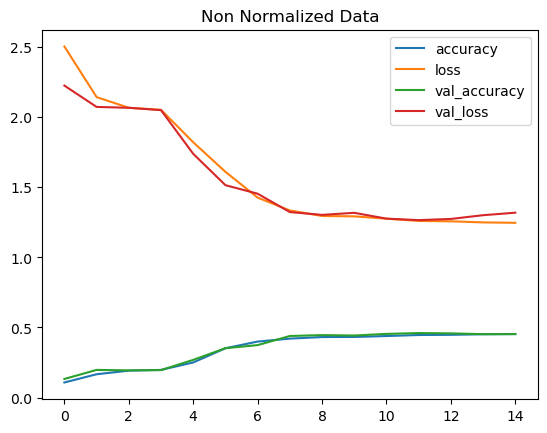

In [37]:
# Plotting Training and Testing Data Loss and Accuracy Curves (Non Normalized):

pd.DataFrame(history_Non_Normal.history).plot()
plt.title("Non Normalized Data")
plt.show()

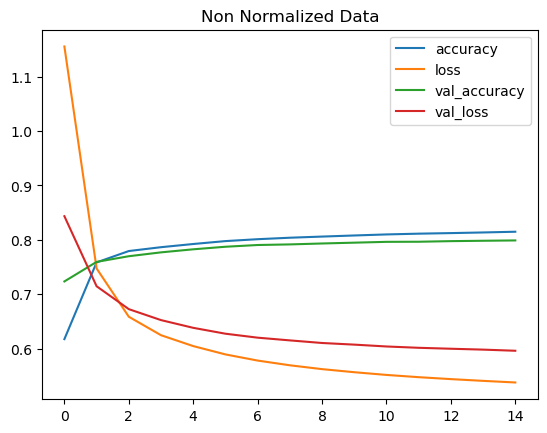

In [38]:
# Plotting Training and Testing Data Loss and Accuracy Curves (Normalized):

pd.DataFrame(history_Normal.history).plot()
plt.title("Non Normalized Data")
plt.show()

From these two plots, we can see how much quicker our model with the normalized data (`model_10`) improved than the model with the non-normalized data (`model_9`).

Note: The same model with even *slightly* different data can produce *dramatically* different results. So when you're comparing models, it's important to make sure you're comparing them on the same criteria (e.g. same architecture but different data or same data but different architecture).

In [39]:
# Finding Ideal Learning Rate Using Learning Rate Callback:

tf.random.set_seed(42)

model_11 = Sequential()

model_11.add(InputLayer(shape= (28,28)))
model_11.add(Flatten())
model_11.add(Dense(4, activation= "relu"))
model_11.add(Dense(4, activation= "relu"))
model_11.add(Dense(10,activation= "softmax"))

model_11.compile(optimizer= tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics= ["accuracy"])

lr_schedular = tf.keras.callbacks.LearningRateScheduler(
                lambda epoch : 1e-3 * (10 ** (epoch/20)))

history_ideal_lr = model_11.fit(train_data,
                               train_labels,
                               epochs= 40,
                               validation_data= (test_data, test_labels),
                               callbacks= [lr_schedular])

Epoch 1/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5133 - loss: 1.3863 - val_accuracy: 0.7497 - val_loss: 0.7104 - learning_rate: 0.0010
Epoch 2/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7795 - loss: 0.6469 - val_accuracy: 0.7846 - val_loss: 0.6184 - learning_rate: 0.0011
Epoch 3/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8030 - loss: 0.5797 - val_accuracy: 0.7971 - val_loss: 0.5804 - learning_rate: 0.0013
Epoch 4/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8132 - loss: 0.5502 - val_accuracy: 0.8051 - val_loss: 0.5593 - learning_rate: 0.0014
Epoch 5/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8174 - loss: 0.5327 - val_accuracy: 0.8131 - val_loss: 0.5448 - learning_rate: 0.0016
Epoch 6/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8212 - loss: 0.5220 - val_accuracy: 0.8159 - val_loss: 0.5357 - learning_rate: 0.0018
Epoch 7/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8239 - l

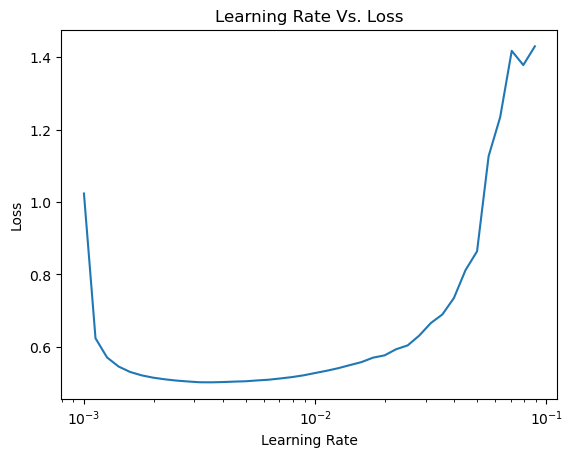

In [42]:
# Plotting Learnig Rate Vs. Loss Curve:

lrs = 1e-3 * (10 ** (tf.range(40)/20))
plt.semilogx(lrs, history_ideal_lr.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Vs. Loss")
plt.show()

In this case, it looks like somewhere close to the default learning rate of the [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) (`0.001`) is the ideal learning rate.

In [43]:
# Creating Same Neural Network as Above With Ideal Learning Rate:

tf.random.set_seed(42)

model_12 = Sequential()

model_12.add(InputLayer(shape= (28,28)))
model_12.add(Flatten())
model_12.add(Dense(4, activation= "relu"))
model_12.add(Dense(4, activation= "relu"))
model_12.add(Dense(10, activation= "softmax"))

model_12.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),
                loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics= ["accuracy"])

history12 = model_12.fit(train_data,
                        train_labels,
                        validation_data= (test_data, test_labels),
                        epochs= 25)

Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4020 - loss: 1.5555 - val_accuracy: 0.7017 - val_loss: 0.8153
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7238 - loss: 0.7663 - val_accuracy: 0.7463 - val_loss: 0.7049
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7540 - loss: 0.6824 - val_accuracy: 0.7586 - val_loss: 0.6723
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7654 - loss: 0.6479 - val_accuracy: 0.7647 - val_loss: 0.6528
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7733 - loss: 0.6243 - val_accuracy: 0.7688 - val_loss: 0.6422
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7796 - loss: 0.6095 - val_accuracy: 0.7729 - val_loss: 0.6293
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7852 - loss: 0.5938 - val_accuracy: 0.7818 - val_loss: 0.6119
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7963 - loss: 0.5769 - 

#### Evaluating The Model:

In [44]:
# Making Predictions Using Model:
y_probs = model_12.predict(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [45]:
y_probs[0]

array([7.12943233e-07, 6.73979685e-07, 3.18859520e-07, 5.13872714e-04,
       1.28908156e-04, 1.61315620e-01, 2.46183426e-05, 1.23965226e-01,
       2.34369258e-03, 7.11706340e-01], dtype=float32)

Our model outputs a list of **prediction probabilities**, meaning, it outputs a number for how likely it thinks a particular class is to be the label.

The higher the number in the prediction probabilities list, the more likely the model believes that is the right class.

To find the highest value we can use the [`argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) method.

In [46]:
y_probs[0].argmax()

9

In [47]:
class_names[9]

'Ankle boot'

In [48]:
class_names[y_probs[0].argmax()]

'Ankle boot'

In [49]:
# Converting All Prediction Probabilities to Labels:

y_pred = y_probs.argmax(axis= 1)

In [50]:
y_pred[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=int64)

In [51]:
# Viewing and Plotting Confusion Matrix Uisng Scikit-Learn:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [52]:
confusion_matrix(test_labels, y_pred)

array([[741,  13,  23,  70,   5,   4, 127,   0,  16,   1],
       [  1, 957,  11,  26,   3,   0,   2,   0,   0,   0],
       [ 18,   6, 764,  11, 109,   0,  89,   0,   2,   1],
       [ 40,  32,  16, 831,  32,   2,  40,   0,   6,   1],
       [  0,   4, 182,  33, 713,   0,  65,   0,   1,   2],
       [  0,   0,   0,   2,   0, 924,   0,  40,   7,  27],
       [132,   9, 141,  45, 138,   3, 507,   0,  25,   0],
       [  0,   0,   0,   0,   0,  41,   0, 912,   0,  47],
       [  2,   1,   0,   7,   7,   8,  53,   8, 909,   5],
       [  0,   0,   0,   1,   1,  27,   0,  41,   4, 926]], dtype=int64)

<Figure size 2000x2000 with 0 Axes>

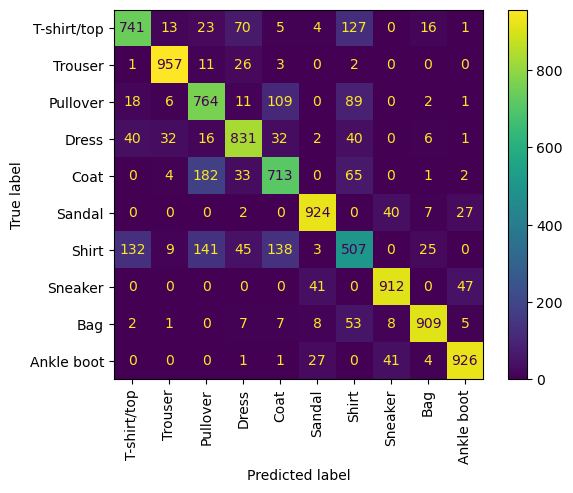

In [58]:
# Plotting Confusion Matrix:

cm = confusion_matrix(test_labels, y_pred)

display_cm = ConfusionMatrixDisplay(cm, display_labels= class_names)

plt.figure(figsize= (10,10), dpi= 200)

display_cm.plot()

plt.xticks(rotation= 90)

plt.show()

Let's create a function to plot a random image along with its prediction and True Label..

Note: Often when working with images and other forms of visual data, it's a good idea to visualize as much as possible to develop a further understanding of the data and the outputs of your model.

In [106]:
import random
def plot_random_image(model, images, true_labels, classes):
    """Picks a random image, plots it and labels it with a predicted and truth
        label.

  Args:
    model: a trained model (trained on data similar to what's in images).
    images: a set of random images (in tensor form).
    true_labels: array of ground truth labels for images.
    classes: array of class names for images.

  Returns:
    A plot of a random image from `images` with a predicted class label 
    from `model`as well as the truth class label from `true_labels`.
  """
        
    # Pick an Random Integer
    i = random.randint(0, len(images))
        
    # Creating Predictions and Target
    target_image = images[i]
        
    pred_probs = model.predict(target_image.reshape(1, 28, 28))
    # have to reshape to get into right size for model
        
    pred_label = classes[pred_probs.argmax()]
        
    true_label = classes[true_labels[i]]
        
    # Plot The random Image:
    plt.imshow(target_image)
        
    # Changing Color of Plot Titles Depending on if Prediction is True or Not:
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"
            
    plt.xlabel(f"(Prediction: {pred_label} {np.round(tf.reduce_max(pred_probs)*100)}%),{true_label}",
              color= color)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


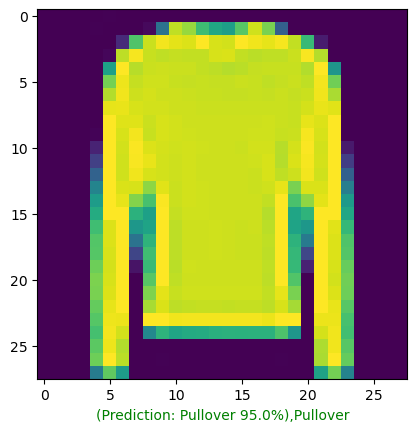

In [111]:
plot_random_image(model=model_12,
                 images= test_data,
                 true_labels= test_labels,
                 classes= class_names)

After running the cell above a few times you'll start to get a visual understanding of the relationship between the model's predictions and the true labels.

It seems to mix up classes which are similar, for example, `Sneaker` with `Ankle boot`.

Looking at the images, you can see how this might be the case.

The overall shape of a `Sneaker` and an `Ankle Boot` are similar.

The overall shape might be one of the patterns the model has learned and so therefore when two images have a similar shape, their predictions get mixed up.

### What patterns is our model learning?

So,a  neural network finds patterns in numbers, but what exactly do these patterns look like?

Let's crack open one of our models and find out.

First, we'll get a list of layers in our most recent model (`model_14`) using the `layers` attribute.

In [112]:
# layers of Out Last, Most Recent Model:
model_12.layers

[<Flatten name=flatten_8, built=True>,
 <Dense name=dense_24, built=True>,
 <Dense name=dense_25, built=True>,
 <Dense name=dense_26, built=True>]

In [113]:
# A Particular Level:
model_12.layers[1]

<Dense name=dense_24, built=True>

We can find the patterns learned by a particular layer using the `get_weights()` method.

The `get_weights()` method returns the **weights** (also known as a weights matrix) and biases (also known as a bias vector) of a particular layer.

In [114]:
# Getting Weights and Biases from a Layer:
weights, biases = model_12.layers[1].get_weights()

In [115]:
weights.shape

(784, 4)

In [116]:
biases.shape

(4,)

The weights matrix is the same shape as the input data, which in our case is 784 (28x28 pixels). And there's a copy of the weights matrix for each neuron the in the selected layer (our selected layer has 4 neurons).

Each value in the weights matrix corresponds to how a particular value in the input data influences the network's decisions.

These values start out as random numbers (they're set by the [`kernel_initializer` parameter](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) when creating a layer, the default is [`"glorot_uniform"`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)) and are then updated to better representative values of the data (non-random) by the neural network during training.

![neural network supervised learning weight updates](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-fashion-mnist-learning.png)



In [117]:
# Bias Vector:
biases

array([ 0.9267388 ,  0.43819034,  1.0875747 , -0.01044397], dtype=float32)

In [118]:
biases.shape

(4,)

Every neuron has a bias vector. Each of these is paired with a weight matrix.

The bias values get initialized as zeroes by default (using the [`bias_initializer` parameter](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The bias vector dictates how much the patterns within the corresponding weights matrix should influence the next layer.

In [119]:
model_12.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │         3,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,632 (37.63 KB)

 Trainable params: 3,210 (12.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,422 (25.09 KB)

## How a model learns (in brief)

A model learns by updating and improving its weight matrices and biases values every epoch (in our case, when we call the `fit()` fucntion).

It does so by comparing the patterns its learned between the data and labels to the actual labels.

If the current patterns (weight matrices and bias values) don't result in a desirable decrease in the loss function (higher loss means worse predictions), the optimizer tries to steer the model to update its patterns in the right way (using the real labels as a reference).

This process of using the real labels as a reference to improve the model's predictions is called [**backpropagation**](https://en.wikipedia.org/wiki/Backpropagation).

In other words, data and labels pass through a model (**forward pass**) and it attempts to learn the relationship between the data and labels.

And if this learned relationship isn't close to the actual relationship or it could be improved, the model does so by going back through itself (**backward pass**) and tweaking its weights matrices and bias values to better represent the data.

https://www.youtube.com/watch?v=IHZwWFHWa-w&ab_channel=3Blue1Brown